In [84]:
import pickle
import os
import io
import cv2
from matplotlib import pyplot as plt
from torch import nn
import torch
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import sys
from torchvision.datasets.folder import default_loader
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix




## Necessary constants

In [86]:
BASELINE = "baseline"
BILATERAL = "bilateral"
CANNY = 'canny'
CLAHE = 'clahe'
BILATERAL_CANNY ='bilateral_canny'
BILATERAL_CLAHE = 'bilateral_clahe'
BILATERAL_CLAHE_CANNY= 'bilateral_clahe_canny'

BATCH_SIZE = 64

root_dir = 'Images'

## Necessary functions

In [87]:
# Dataset classes for the different filters and the combinations of filters. 
# Applies the filters on the images before transforming the image into a tensor

class Dataset(datasets.ImageFolder):
    def __init__(self, root, parameter_dict, loader=default_loader, is_valid_file=None):
        super(Dataset, self).__init__(root=root, loader=loader, is_valid_file=is_valid_file)
        assert 'gray_scale' in parameter_dict
        self.gray_scale = parameter_dict['gray_scale']
        self.mean = IMAGENET_DEFAULT_MEAN
        self.std = IMAGENET_DEFAULT_STD
    
    def __getitem__(self, index):
        image_path, target = self.samples[index]
        img = cv2.imread(image_path)
        if self.gray_scale:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            self.mean = [0.5]
            self.std = [0.5]
        tensor = transforms.ToTensor()(img)
        sample = transforms.Normalize(self.mean, self.std)(tensor)
        return sample, target, index
        
class NoiseReductionDataset(datasets.ImageFolder):
    def __init__(self, root, parameter_dict, loader=default_loader, is_valid_file=None):
        super(NoiseReductionDataset, self).__init__(root=root, loader=loader, is_valid_file=is_valid_file)
        assert 'gray_scale' in parameter_dict
        assert 'd' in parameter_dict
        assert 'sigmaColor' in parameter_dict
        assert 'sigmaSpace' in parameter_dict

        self.gray_scale = parameter_dict['gray_scale']
        self.mean = IMAGENET_DEFAULT_MEAN
        self.std = IMAGENET_DEFAULT_STD
        self.d = parameter_dict['d']
        self.sigmaColor = parameter_dict['sigmaColor']
        self.sigmaSpace = parameter_dict['sigmaSpace']
    
    def __getitem__(self, index):
        image_path, target = self.samples[index]
        img = cv2.imread(image_path)
        if self.gray_scale:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            self.mean = [0.5]
            self.std = [0.5]
        ## OBS: not sure about d, sigmaColor and sigmaSpace (15, 75, 75)
        noiseless = cv2.bilateralFilter(img, self.d, self.sigmaColor, self.sigmaSpace)
        tensor = transforms.ToTensor()(noiseless)
        sample = transforms.Normalize(self.mean, self.std)(tensor)
        return sample, target, index

class EdgeDetectionDataset(datasets.ImageFolder):
    def __init__(self, root, parameter_dict, loader=default_loader, is_valid_file=None):
        super(EdgeDetectionDataset, self).__init__(root=root, loader=loader, is_valid_file=is_valid_file)
        assert 'gray_scale' in parameter_dict
        assert 'low_tresh' in parameter_dict
        assert 'high_tresh' in parameter_dict

        self.gray_scale = parameter_dict['gray_scale']
        self.mean = IMAGENET_DEFAULT_MEAN
        self.std = IMAGENET_DEFAULT_STD
        self.low_tresh = parameter_dict['low_tresh']
        self.high_tresh = parameter_dict['high_tresh']

    def __getitem__(self, index):
        image_path, target = self.samples[index]
        img = cv2.imread(image_path)
        if self.gray_scale:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            self.mean = [0.5]
            self.std = [0.5]
        ## OBS: not sure about minVal and maxVal (100, 200) also need to look at aperture_size (size of Sobel kernel) and  L2gradient
        edge = cv2.Canny(img, self.low_tresh, self.high_tresh)
        tensor = transforms.ToTensor()(edge)
        sample = transforms.Normalize(self.mean, self.std)(tensor)
        return sample, target, index

class ContrastEnhancingDataset(datasets.ImageFolder):
    def __init__(self, root, parameter_dict, loader=default_loader, is_valid_file=None):
        super(ContrastEnhancingDataset, self).__init__(root=root, loader=loader, is_valid_file=is_valid_file)
        assert 'gray_scale' in parameter_dict
        assert 'clipLimit' in parameter_dict
        assert 'tileGridSize' in parameter_dict

        self.gray_scale = parameter_dict['gray_scale']
        self.mean = IMAGENET_DEFAULT_MEAN
        self.std = IMAGENET_DEFAULT_STD
        self.clipLimit = parameter_dict['clipLimit']
        self.tileGridSize = parameter_dict['tileGridSize']
    
    def __getitem__(self, index):
        image_path, target = self.samples[index]
        img = cv2.imread(image_path)
        if self.gray_scale:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            self.mean = [0.5]
            self.std = [0.5]
        ## OBS: not sure about clipLimit=2.0, tileGridSize=(8,8)
        clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
        enhanced = clahe.apply(img)
        tensor = transforms.ToTensor()(enhanced)
        sample = transforms.Normalize(self.mean, self.std)(tensor)
        return sample, target, index

class BilateralCannyDataset(datasets.ImageFolder):
    def __init__(self, root, parameter_dict, loader=default_loader, is_valid_file=None):
        super(BilateralCannyDataset, self).__init__(root=root, loader=loader, is_valid_file=is_valid_file)
        assert 'gray_scale' in parameter_dict
        assert 'low_tresh' in parameter_dict
        assert 'high_tresh' in parameter_dict
        assert 'd' in parameter_dict
        assert 'sigmaColor' in parameter_dict
        assert 'sigmaSpace' in parameter_dict

        self.gray_scale = parameter_dict['gray_scale']
        self.mean = IMAGENET_DEFAULT_MEAN
        self.std = IMAGENET_DEFAULT_STD
        self.low_tresh = parameter_dict['low_tresh']
        self.high_tresh = parameter_dict['high_tresh']
        self.d = parameter_dict['d']
        self.sigmaColor = parameter_dict['sigmaColor']
        self.sigmaSpace = parameter_dict['sigmaSpace']
    
    def __getitem__(self, index):
        image_path, target = self.samples[index]
        img = cv2.imread(image_path)
        if self.gray_scale:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            self.mean = [0.5]
            self.std = [0.5]
        noiseless = cv2.bilateralFilter(img, self.d, self.sigmaColor, self.sigmaSpace)
        edge = cv2.Canny(noiseless, self.low_tresh, self.high_tresh)
        tensor = transforms.ToTensor()(edge)
        sample = transforms.Normalize(self.mean, self.std)(tensor)
        return sample, target, index

class BilateralClaheDataset(datasets.ImageFolder):
    def __init__(self, root, parameter_dict, loader=default_loader, is_valid_file=None):
        super(BilateralClaheDataset, self).__init__(root=root, loader=loader, is_valid_file=is_valid_file)
        assert 'gray_scale' in parameter_dict
        assert 'clipLimit' in parameter_dict
        assert 'tileGridSize' in parameter_dict
        assert 'd' in parameter_dict
        assert 'sigmaColor' in parameter_dict
        assert 'sigmaSpace' in parameter_dict

        self.gray_scale = parameter_dict['gray_scale']
        self.mean = IMAGENET_DEFAULT_MEAN
        self.std = IMAGENET_DEFAULT_STD
        self.clipLimit = parameter_dict['clipLimit']
        self.tileGridSize = parameter_dict['tileGridSize']
        self.d = parameter_dict['d']
        self.sigmaColor = parameter_dict['sigmaColor']
        self.sigmaSpace = parameter_dict['sigmaSpace']
    
    def __getitem__(self, index):
        image_path, target = self.samples[index]
        img = cv2.imread(image_path)
        if self.gray_scale:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            self.mean = [0.5]
            self.std = [0.5]
        noiseless = cv2.bilateralFilter(img, self.d, self.sigmaColor, self.sigmaSpace)
        clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
        enhanced = clahe.apply(noiseless)
        tensor = transforms.ToTensor()(enhanced)
        sample = transforms.Normalize(self.mean, self.std)(tensor)
        return sample, target, index

class BilateralClaheCannyDataset(datasets.ImageFolder):
    def __init__(self, root, parameter_dict, loader=default_loader, is_valid_file=None):
        super(BilateralClaheCannyDataset, self).__init__(root=root, loader=loader, is_valid_file=is_valid_file)
        assert 'gray_scale' in parameter_dict
        assert 'low_tresh' in parameter_dict
        assert 'high_tresh' in parameter_dict
        assert 'd' in parameter_dict
        assert 'sigmaColor' in parameter_dict
        assert 'sigmaSpace' in parameter_dict
        assert 'clipLimit' in parameter_dict
        assert 'tileGridSize' in parameter_dict

        self.gray_scale = parameter_dict['gray_scale']
        self.mean = IMAGENET_DEFAULT_MEAN
        self.std = IMAGENET_DEFAULT_STD
        self.low_tresh = parameter_dict['low_tresh']
        self.high_tresh = parameter_dict['high_tresh']
        self.d = parameter_dict['d']
        self.sigmaColor = parameter_dict['sigmaColor']
        self.sigmaSpace = parameter_dict['sigmaSpace']
        self.clipLimit = parameter_dict['clipLimit']
        self.tileGridSize = parameter_dict['tileGridSize']
    
    def __getitem__(self, index):
        image_path, target = self.samples[index]
        img = cv2.imread(image_path)
        if self.gray_scale:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            self.mean = [0.5]
            self.std = [0.5]
        noiseless = cv2.bilateralFilter(img, self.d, self.sigmaColor, self.sigmaSpace)
        clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
        enhanced = clahe.apply(noiseless)
        edge = cv2.Canny(enhanced, self.low_tresh, self.high_tresh)
        tensor = transforms.ToTensor()(edge)
        sample = transforms.Normalize(self.mean, self.std)(tensor)
        return sample, target, index

In [53]:
# Make dataloader

def get_dataset(root_dir, mode, classe, parameter_dict):
    path = os.path.join(root_dir, mode)
    dataset = classe(path, parameter_dict)
    return dataset

def dataloader(root_dir, mode, classe, parameter_dict):
    dataset = get_dataset(root_dir, mode, classe, parameter_dict)
    data_loader = DataLoader(
        dataset,
        batch_size = BATCH_SIZE,
        shuffle = True
    )
    return data_loader, dataset

In [54]:
# Build the baseline model

class ConvolutionalNet(nn.Module):
    def __init__(self, gray_scale=False):
        super().__init__()
        input_dimention = 1 if gray_scale else 3
        self.conv1 = nn.Conv2d(input_dimention, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(73926, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch_size
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Prediction on test dataset

### Functions for plotting

In [123]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

def plot_accuracy(history):
    accuracy = history['accuracy']
    plt.ylim(0.85,1.0)
    plt.plot(accuracy['train'])
    plt.plot(accuracy['val'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc="lower right")
    plt.show()
    
def plot_loss(history):
    loss = history['losses']
    plt.ylim(0.0,0.45)
    plt.plot(loss['train'])
    plt.plot(loss['val'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc="lower left")
    plt.show()
  
def load_history(path, cuda):
    with open(path, 'rb') as f:
        if cuda:
            history = CPU_Unpickler(f).load()
        else:
            history = pickle.load(f)
    print('Best accuracy:', history['best acc'])
    return history

def plotting(path_to_history, cuda=False):
    history = load_history(path_to_history, cuda)
    plot_loss(history)
    plot_accuracy(history)

### Functions for perdiction and evaluation

In [56]:
def plot_confusion_matrix(confusion_matrix):

    ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')

    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')

    # Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    # Display the visualization of the Confusion Matrix.
    plt.show()

In [57]:
def evaluation(ground_truth, predictions):
    '''
        Function for plotting the confusion_matrix of the predictions

    '''
    target_names = ['Negative (0)', 'Positive (1)']
    print(classification_report(ground_truth, predictions, target_names=target_names, digits=4))
    print(accuracy_score(ground_truth, predictions))
    cf_matrix = confusion_matrix(ground_truth, predictions)
    plot_confusion_matrix(cf_matrix)

In [88]:
def perdict(RUN_TYPE, GRAY_SCALE, model_path, cuda=False):
    '''
        Function for plotting the confusion_matrix of the predictions

    '''
    if cuda:
        model = torch.load(model_path, map_location=torch.device('cpu'))
    else:
        model = torch.load(model_path)

    if RUN_TYPE == BASELINE:
        dataloder_test, dataset_test = dataloader(root_dir, "test", Dataset, {'gray_scale': GRAY_SCALE})
    elif RUN_TYPE == BILATERAL:
        # Bilateral
        parameter_dict = {'gray_scale': GRAY_SCALE, 'd': 15, 'sigmaColor': 50, 'sigmaSpace': 100}
        dataloder_test, dataset_test = dataloader(root_dir, "test", NoiseReductionDataset, parameter_dict )
    elif RUN_TYPE == CANNY:
        parameter_dict = {'gray_scale': GRAY_SCALE, 'low_tresh': 50, 'high_tresh': 230}
        dataloder_test, dataset_test = dataloader(root_dir, "test", EdgeDetectionDataset, parameter_dict )
    elif RUN_TYPE == CLAHE:
        parameter_dict = {'gray_scale': GRAY_SCALE, 'clipLimit': 1.0, 'tileGridSize': (8,8)}
        dataloder_test, dataset_test = dataloader(root_dir, "test", ContrastEnhancingDataset, parameter_dict )
    elif RUN_TYPE == BILATERAL_CANNY:
        parameter_dict = {'gray_scale': GRAY_SCALE, 'd': 15, 'sigmaColor': 50, 'sigmaSpace': 100, 'low_tresh': 50, 'high_tresh': 230}
        dataloder_test, dataset_test = dataloader(root_dir, "test", BilateralCannyDataset, parameter_dict)
    elif RUN_TYPE == BILATERAL_CLAHE:
        parameter_dict = {'gray_scale': GRAY_SCALE, 'd': 15, 'sigmaColor': 50, 'sigmaSpace': 100, 'clipLimit': 1.0, 'tileGridSize': (8,8)}
        dataloder_test, dataset_test = dataloader(root_dir, "test", BilateralClaheDataset, parameter_dict)
    elif RUN_TYPE == BILATERAL_CLAHE_CANNY:
        parameter_dict = {'gray_scale': GRAY_SCALE, 'd': 15, 'sigmaColor': 50, 'sigmaSpace': 100, 'clipLimit': 1.0, 'tileGridSize': (8,8), 'low_tresh': 50, 'high_tresh': 230}
        dataloder_test, dataset_test = dataloader(root_dir, "test", BilateralClaheCannyDataset, parameter_dict)
    else:
        raise Exception("Unknown run tye")


    print("testing ", RUN_TYPE, " with grayscale ", GRAY_SCALE)

    print(f"Length of dataset: {len(dataset_test)}, classes in dataset: {dataset_test.classes}")
    inputs, classes, indices = next(iter(dataloder_test))
    print("Shape of image:", inputs.shape)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in dataset_test.classes}
    total_pred = {classname: 0 for classname in dataset_test.classes}
    classlabels = {0: 'Negative', 1: 'Positive'}

    full_pred_list = []
    full_ground_truth = []
    # again no gradients needed
    i=0
    with torch.no_grad():
        for data in dataloder_test:
            i+=1
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            # Print loading bar
            sys.stdout.write('\r')
            percentage = 100/len(dataset_test)*BATCH_SIZE*i
            sys.stdout.write("Prediction:[%-20s] %.2f%%" % ('='*round(percentage/5), percentage))
            sys.stdout.flush()


            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                full_pred_list.append(prediction.item())
                full_ground_truth.append(label.item())
                classs = label.item()
                if label == prediction:
                    correct_pred[classlabels[classs]] += 1
                total_pred[classlabels[classs]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                    accuracy))

    evaluation(full_ground_truth, full_pred_list)
    
    

### Baseline

testing  baseline  with grayscale  True
Length of dataset: 6000, classes in dataset: ['Negative', 'Positive']
Shape of image: torch.Size([64, 1, 227, 227])
Prediction:[====================] 100.27%Accuracy for class Negative is: 98.7 %
Accuracy for class Positive is: 98.9 %
              precision    recall  f1-score   support

Negative (0)     0.9887    0.9873    0.9880      3000
Positive (1)     0.9874    0.9887    0.9880      3000

    accuracy                         0.9880      6000
   macro avg     0.9880    0.9880    0.9880      6000
weighted avg     0.9880    0.9880    0.9880      6000

0.988


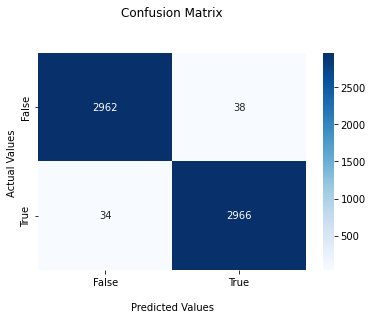

In [59]:
model_path = 'models/grayscale_dropout_20_01_2022_15:07:31_model.pth'
RUN_TYPE = BASELINE
GRAY_SCALE = True

perdict(RUN_TYPE, GRAY_SCALE, model_path)

Best accuracy: 0.9893333333333333


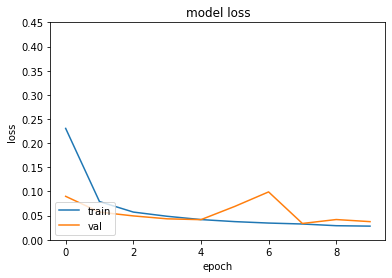

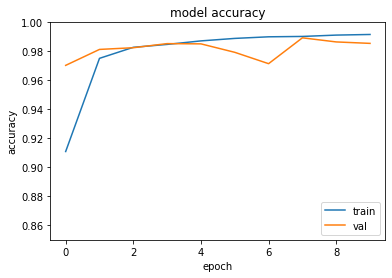

In [124]:
history_path = 'models/grayscale_dropout_20_01_2022_15:07:31_history.json'
plotting(history_path)

### Bilateral

testing  bilateral  with grayscale  True
Length of dataset: 6000, classes in dataset: ['Negative', 'Positive']
Shape of image: torch.Size([64, 1, 227, 227])
Prediction:[====================] 100.27%Accuracy for class Negative is: 98.9 %
Accuracy for class Positive is: 97.4 %
              precision    recall  f1-score   support

Negative (0)     0.9747    0.9887    0.9816      3000
Positive (1)     0.9885    0.9743    0.9814      3000

    accuracy                         0.9815      6000
   macro avg     0.9816    0.9815    0.9815      6000
weighted avg     0.9816    0.9815    0.9815      6000

0.9815


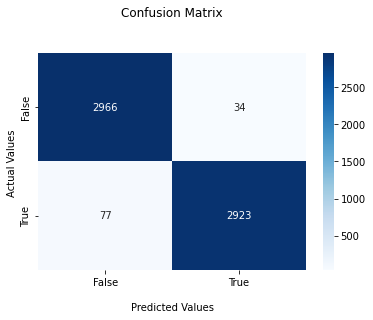

In [30]:
model_path = 'models/bilateral_grey_20_01_2022_17:27:39_model.pth'
RUN_TYPE = BILATERAL
GRAY_SCALE = True

perdict(RUN_TYPE, GRAY_SCALE, model_path)

Best accuracy: 0.985


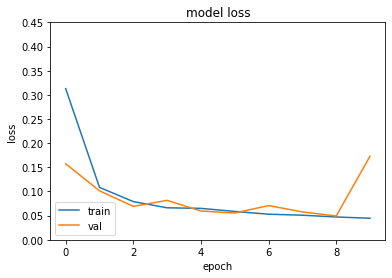

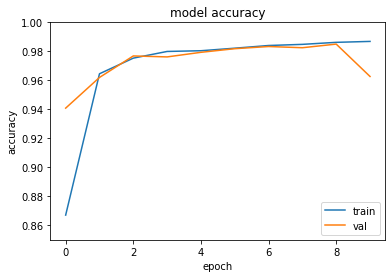

In [125]:
history_path = 'models/bilateral_grey_20_01_2022_17:27:39_history.json'
plotting(history_path)

### Canny

testing  canny  with grayscale  True
Length of dataset: 6000, classes in dataset: ['Negative', 'Positive']
Shape of image: torch.Size([64, 1, 227, 227])
Prediction:[====================] 100.27%Accuracy for class Negative is: 92.0 %
Accuracy for class Positive is: 97.4 %
              precision    recall  f1-score   support

Negative (0)     0.9722    0.9200    0.9454      3000
Positive (1)     0.9241    0.9737    0.9482      3000

    accuracy                         0.9468      6000
   macro avg     0.9481    0.9468    0.9468      6000
weighted avg     0.9481    0.9468    0.9468      6000

0.9468333333333333


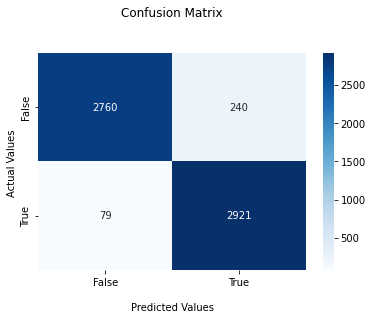

In [60]:
model_path = 'models/canny_grey_21_01_2022_13:59:34_model.pth'
RUN_TYPE = CANNY
GRAY_SCALE = True

perdict(RUN_TYPE, GRAY_SCALE, model_path)

Best accuracy: 0.9418333333333333


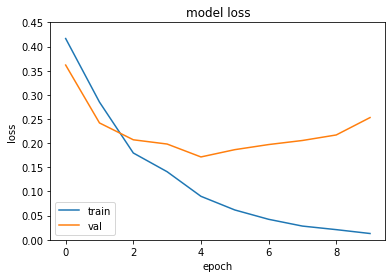

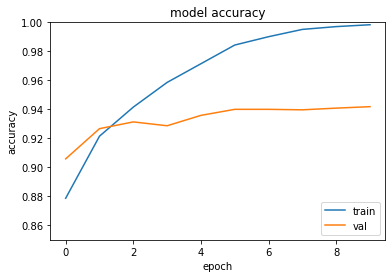

In [126]:
history_path = 'models/canny_grey_21_01_2022_13:59:34_history.json'
plotting(history_path)

### Clahe

testing  clahe  with grayscale  True
Length of dataset: 6000, classes in dataset: ['Negative', 'Positive']
Shape of image: torch.Size([64, 1, 227, 227])
Prediction:[====================] 100.27%Accuracy for class Negative is: 99.3 %
Accuracy for class Positive is: 98.5 %
              precision    recall  f1-score   support

Negative (0)     0.9854    0.9930    0.9892      3000
Positive (1)     0.9929    0.9853    0.9891      3000

    accuracy                         0.9892      6000
   macro avg     0.9892    0.9892    0.9892      6000
weighted avg     0.9892    0.9892    0.9892      6000

0.9891666666666666


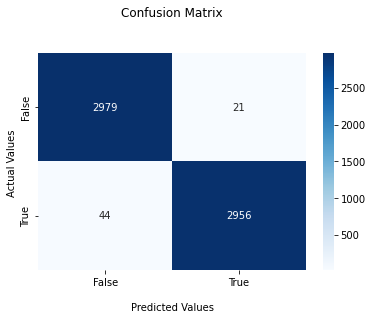

In [62]:
model_path = 'models/clahe_grey_20_01_2022_18:22:38_model.pth'
RUN_TYPE = CLAHE
GRAY_SCALE = True

perdict(RUN_TYPE, GRAY_SCALE, model_path)

Best accuracy: 0.9893333333333333


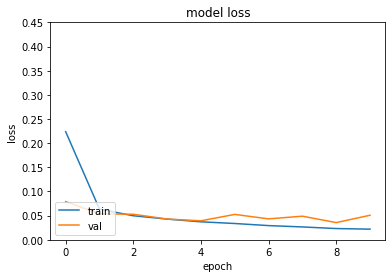

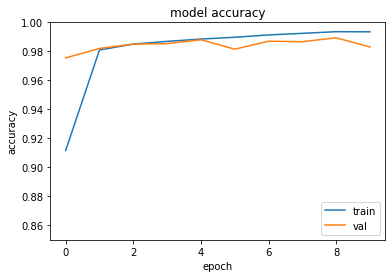

In [127]:
history_path = 'models/clahe_grey_20_01_2022_18:22:38_history.json'
plotting(history_path)

### Bilateral and canny

testing  bilateral_canny  with grayscale  True
Length of dataset: 6000, classes in dataset: ['Negative', 'Positive']
Shape of image: torch.Size([64, 1, 227, 227])
Prediction:[====================] 100.27%Accuracy for class Negative is: 98.6 %
Accuracy for class Positive is: 95.7 %
              precision    recall  f1-score   support

Negative (0)     0.9582    0.9863    0.9721      3000
Positive (1)     0.9859    0.9570    0.9712      3000

    accuracy                         0.9717      6000
   macro avg     0.9721    0.9717    0.9717      6000
weighted avg     0.9721    0.9717    0.9717      6000

0.9716666666666667


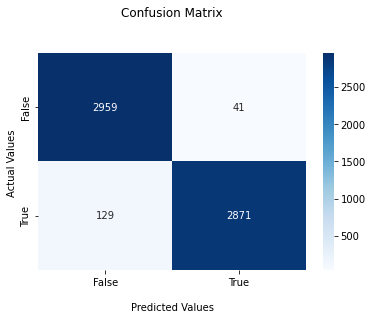

In [91]:
model_path = 'models/bilateral_canny_grey_21_01_2022_16_11_54_model.pth'
RUN_TYPE = BILATERAL_CANNY
GRAY_SCALE = True

perdict(RUN_TYPE, GRAY_SCALE, model_path, True)

Best accuracy: 0.9713333333333333


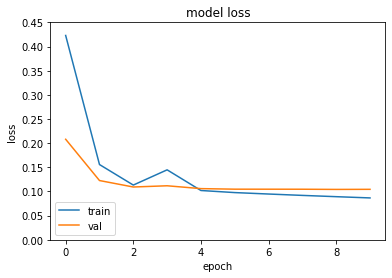

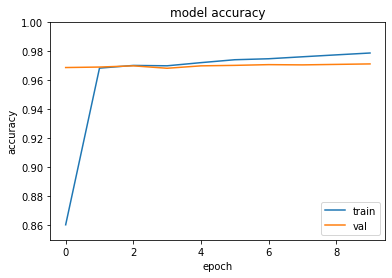

In [128]:
history_path = 'models/bilateral_canny_grey_21_01_2022_16_11_54_history.json'
plotting(history_path, True)

### Bilateral clahe

testing  bilateral_clahe  with grayscale  True
Length of dataset: 6000, classes in dataset: ['Negative', 'Positive']
Shape of image: torch.Size([64, 1, 227, 227])
Prediction:[====================] 100.27%Accuracy for class Negative is: 99.1 %
Accuracy for class Positive is: 97.9 %
              precision    recall  f1-score   support

Negative (0)     0.9793    0.9913    0.9853      3000
Positive (1)     0.9912    0.9790    0.9851      3000

    accuracy                         0.9852      6000
   macro avg     0.9852    0.9852    0.9852      6000
weighted avg     0.9852    0.9852    0.9852      6000

0.9851666666666666


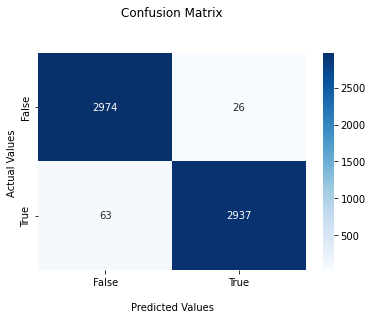

In [94]:
model_path = 'models/bilateral_clahe_grey_21_01_2022_18:39:41_model.pth'
RUN_TYPE = BILATERAL_CLAHE
GRAY_SCALE = True

perdict(RUN_TYPE, GRAY_SCALE, model_path)

Best accuracy: 0.9865


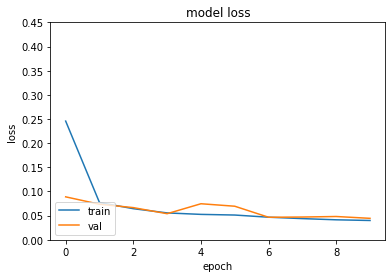

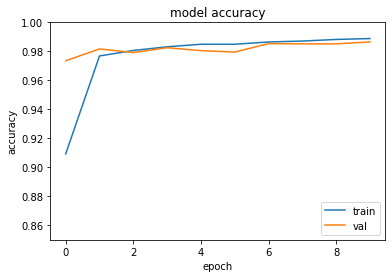

In [129]:
history_path = 'models/bilateral_clahe_grey_21_01_2022_18:39:41_history.json'
plotting(history_path)

### Bilateral clahe and canny

testing  bilateral_clahe_canny  with grayscale  True
Length of dataset: 6000, classes in dataset: ['Negative', 'Positive']
Shape of image: torch.Size([64, 1, 227, 227])
Prediction:[====================] 100.27%Accuracy for class Negative is: 97.9 %
Accuracy for class Positive is: 97.1 %
              precision    recall  f1-score   support

Negative (0)     0.9709    0.9793    0.9751      3000
Positive (1)     0.9792    0.9707    0.9749      3000

    accuracy                         0.9750      6000
   macro avg     0.9750    0.9750    0.9750      6000
weighted avg     0.9750    0.9750    0.9750      6000

0.975


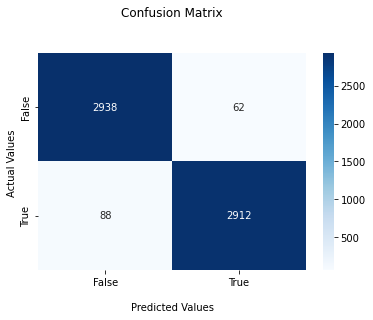

In [99]:
model_path = 'models/bilateral_clahe_canny_grey_21_01_2022_20_17_28_model.pth'
RUN_TYPE = BILATERAL_CLAHE_CANNY
GRAY_SCALE = True

perdict(RUN_TYPE, GRAY_SCALE, model_path, cuda=True)

Best accuracy: 0.9768333333333333


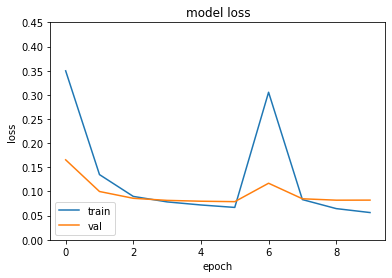

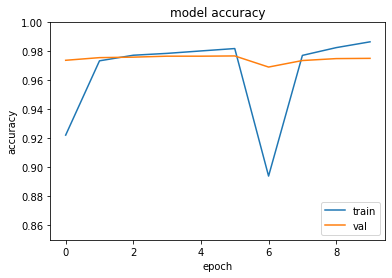

In [130]:
history_path = 'models/bilateral_clahe_canny_grey_21_01_2022_20_17_28_history.json'
plotting(history_path, cuda=True)

### Resnet

testing  baseline  with grayscale  False
Length of dataset: 6000, classes in dataset: ['Negative', 'Positive']
Shape of image: torch.Size([64, 3, 227, 227])
Prediction:[====================] 100.27%Accuracy for class Negative is: 99.8 %
Accuracy for class Positive is: 99.6 %
              precision    recall  f1-score   support

Negative (0)     0.9963    0.9977    0.9970      3000
Positive (1)     0.9977    0.9963    0.9970      3000

    accuracy                         0.9970      6000
   macro avg     0.9970    0.9970    0.9970      6000
weighted avg     0.9970    0.9970    0.9970      6000

0.997


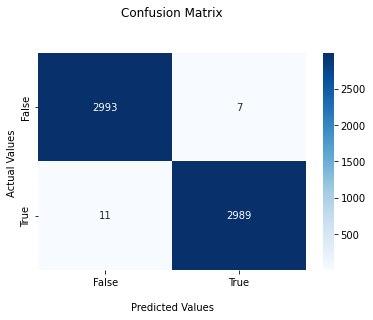

In [85]:
model_path = 'models/resnet50_20_01_2022_20_55_44_model.pth'
RUN_TYPE = BASELINE
GRAY_SCALE = False

perdict(RUN_TYPE, GRAY_SCALE, model_path, True)

Best accuracy: 0.9971666666666666


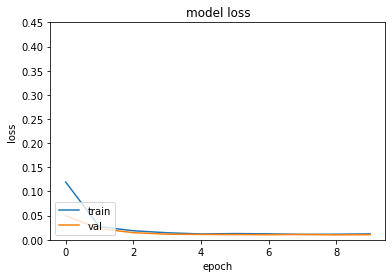

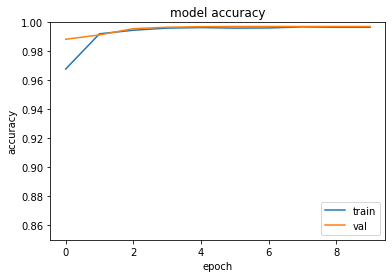

In [131]:
history_path = 'models/resnet50_20_01_2022_20_55_44_history.json'
plotting(history_path, True)